# Simulated MR artifacts (torchio)

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#default_exp mri

If you use these transformations which all build on TorchIO, please cite the following paper:
> Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696

In [ ]:
#exporti
from torchio.transforms import Spike
from misas.core import gif_series

## Spike artifact

In [ ]:
#exporti
#from fastai.vision import open_image, Image, open_mask
from PIL import Image, ImageEnhance, ImageShow, ImageOps
import numpy as np
from misas.core import get_generic_series, plot_series, eval_generic_series
from misas.fastai_model import Fastai2_model
from functools import partial
import torch

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
#img=Image.open("example/b0/images/val_example_0.png")

In [ ]:
#export
def spikeTransform(image, intensityFactor, spikePosition=[.1,.1]):
    #data = image.data[0].unsqueeze(0)
    #data = np.array(image)[0].unsequeeze(0)
    image = np.array(image)[:,:,0]
    image = np.expand_dims(np.array(image), 0)
    image = image/255
    spikePosition = [[0.0] + spikePosition]
    spike = Spike(spikePosition, intensityFactor)
    #print(np.array(image).shape)
    image = spike.add_artifact(image, spikePosition, intensityFactor)[0]
    image = torch.stack((image,image,image))
    image = np.array((torch.clamp(image,0,1)))
    image = image*255
    image = image.astype(np.uint8)
    image = np.moveaxis(image, 0, 2)
    image = Image.fromarray(image)
    return image

def get_spike_series(image, model, start=0, end=2.5, step=.5, spikePosition=[.1,.1], **kwargs):
    return get_generic_series(image,model,partial(spikeTransform,spikePosition=spikePosition), start=start, end=end, step=step, **kwargs)

In [ ]:
fname = "example/b0/images/val_example_0.png"
img = lambda: Image.open(fname).resize((256,256)).convert ("RGB")
trueMask = lambda: Image.open(fname.replace("image","mask"))

In [ ]:
def interactiveSpikeTransform(intensity, x, y):
    plt.imshow(spikeTransform(img(), intensity, [x,y])) #figsize=(8,8))

In [ ]:
interactive_plot = interactive(
    interactiveSpikeTransform,
    intensity=widgets.FloatSlider(min=0, max=3, step=.1, value=1, continuous_update=True),
    x=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True),
    y=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True)
)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='intensity', max=3.0), FloatSlider(value=0.5, descrip…

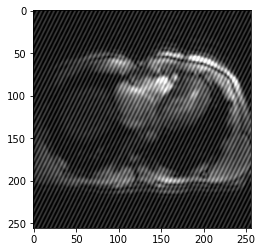

In [ ]:
plt.imshow(spikeTransform(img(), .8, [.4,.3]), cmap="bone") #figsize=(8,8), 

In [ ]:
def label_func(x):
    pass
def acc_seg(input, target):
    pass
def diceComb(input, targs):
    pass
def diceLV(input, targs):
    pass
def diceMY(input, targs):
    pass

In [ ]:
trainedModel = Fastai2_model('chfc-cmi/transversal-cmr-seg', 'b0_transversal_5_5', force_reload=False)

Downloading: "https://github.com/chfc-cmi/transversal-cmr-seg/archive/master.zip" to /home/csa84mikl/.cache/torch/hub/master.zip


  0%|          | 0.00/209M [00:00<?, ?B/s]

### Spike intensity

In [ ]:
series = get_spike_series(img(), trainedModel, truth=trueMask(), tfm_y=False)

  0%|          | 0/5 [00:00<?, ?it/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


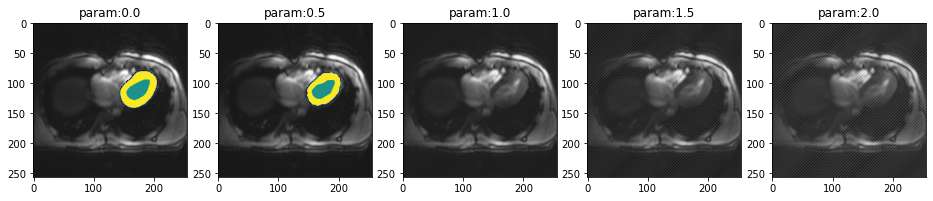

In [ ]:
plot_series(series)

  0%|          | 0/5 [00:00<?, ?it/s]

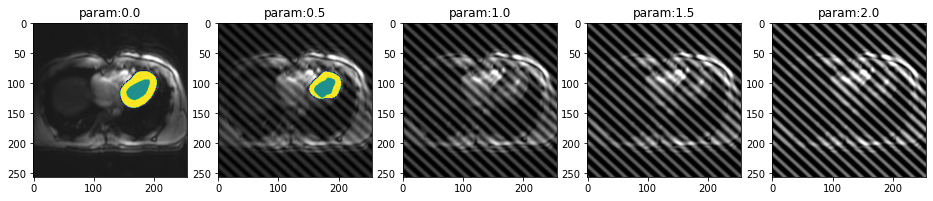

In [ ]:
spikePosition = [.45,.55]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

  0%|          | 0/5 [00:00<?, ?it/s]

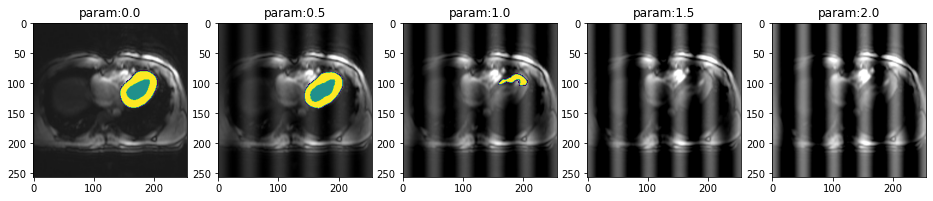

In [ ]:
spikePosition = [.5,.52]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

In [ ]:
#export
def eval_spike_series(image, mask, model, step=.1, start=0, end=2.5, spikePosition=[.1,.1], param_name="intensity", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(spikeTransform,spikePosition=spikePosition),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name=param_name,
        **kwargs
    )

  0%|          | 0/25 [00:00<?, ?it/s]

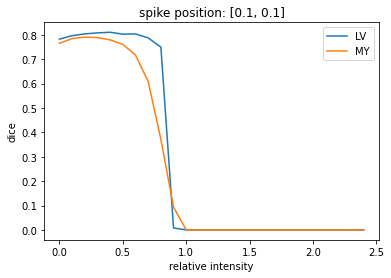

In [ ]:
results = eval_spike_series(img(), trueMask(), trainedModel)
plt.plot(results['intensity'], results['c1'], label='LV')
plt.plot(results['intensity'], results['c2'], label='MY')
plt.legend()
plt.xlabel('relative intensity')
plt.ylabel('dice')
_ = plt.title(f'spike position: {[.1,.1]}')

### Spike position

In [ ]:
#export
def spikePosTransform(image, spikePositionX, spikePositionY=0.1, intensityFactor=0.5):
    image = np.array(image)[:,:,0]
    image = np.expand_dims(np.array(image), 0)
    image = image/255
    spikePosition = [[0.0] + [spikePositionX, spikePositionY]]
    spike = Spike(spikePosition, intensityFactor)
    image = spike.add_artifact(image, spikePosition, intensityFactor)[0]
    image = torch.stack((image,image,image))
    image = np.array((torch.clamp(image,0,1)))
    image = image*255
    image = image.astype(np.uint8)
    image = np.moveaxis(image, 0, 2)
    image = Image.fromarray(image)
    return image

def get_spike_pos_series(image, model, start=0.1, end=0.9, step=.1, intensityFactor=0.5, spikePositionY=0.1, **kwargs):
    return get_generic_series(image,
                              model,
                              #spikePosTransform,
                              partial(spikePosTransform, intensityFactor=intensityFactor, spikePositionY=spikePositionY),
                              start=start, 
                              end=end,
                              step=step,
                              **kwargs)

  0%|          | 0/8 [00:00<?, ?it/s]

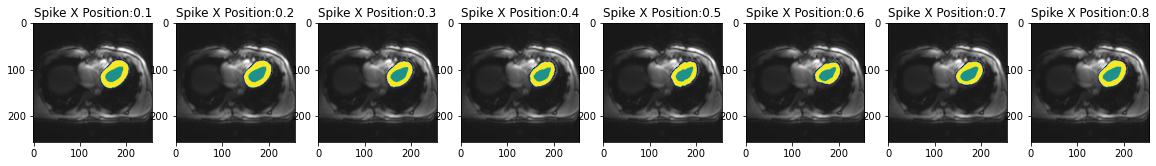

In [ ]:
series = get_spike_pos_series(img(), trainedModel, intensityFactor=0.1, spikePositionY=0.1)
plot_series(series, nrow=1, figsize=(20,15), param_name='Spike X Position')

In [ ]:
#export
def eval_spike_pos_series(image, mask, model, step=0.1, start=0.1, end=0.9, intensityFactor=0.1, param_name="Spike X Position", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(spikePosTransform, intensityFactor=intensityFactor),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name=param_name,
        **kwargs
    )

  0%|          | 0/16 [00:00<?, ?it/s]

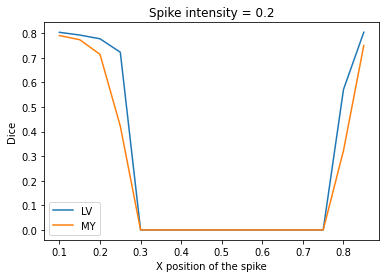

In [ ]:
intensityFactor = 0.2
results = eval_spike_pos_series(img(), trueMask(), trainedModel, step=0.05, intensityFactor=intensityFactor)
plt.plot(results['Spike X Position'], results['c1'], label='LV')
plt.plot(results['Spike X Position'], results['c2'], label='MY')
plt.legend()
plt.xlabel('X position of the spike')
plt.ylabel('Dice')
_ = plt.title(f'Spike intensity = {intensityFactor}')

In [ ]:
gif_series(
    get_spike_pos_series(img(),trainedModel, start=0.1, end=0.9 ,step=0.1, intensityFactor=0.2),
    "example/kaggle/spike_pos.gif",
    param_name="Spike X Position",
    duration=400
)

  0%|          | 0/8 [00:00<?, ?it/s]

![segmentation sensitivity to spike position](example/kaggle/spike_pos.gif)

## Bias Field ($B_0$)

The bias field function is still experimental as it lacks configurability. To make it deterministic all coefficients are set to the exact same value. This represents only one specific possibility of field inhomogeneity.

In [ ]:
#exporti
from torchio import RandomBiasField, BiasField

In [ ]:
image = img()
image = np.array(image)[:,:,0]
image = np.expand_dims(np.array(image), 0)
image = np.expand_dims(np.array(image), 0)
image.shape

(1, 1, 256, 256)

In [ ]:
coefficients = RandomBiasField().get_params(3,[-.3,-.3])

In [ ]:
bf = BiasField.generate_bias_field(image, order=3, coefficients=coefficients)

In [ ]:
bf[0].min()
print(bf)

[[[1.8221189  1.8051496  1.7885349  ... 0.55911684 0.5539707  0.5488116 ]
  [1.8051496  1.7884369  1.7720731  ... 0.5565225  0.5513902  0.54624504]
  [1.7885349  1.7720731  1.7559547  ... 0.5539604  0.5488416  0.54371005]
  ...
  [0.55911684 0.5565225  0.5539604  ... 0.05464021 0.05339407 0.05216679]
  [0.5539707  0.5513902  0.5488416  ... 0.05339407 0.05217157 0.05096772]
  [0.5488116  0.54624504 0.54371005 ... 0.05216679 0.05096772 0.04978706]]]


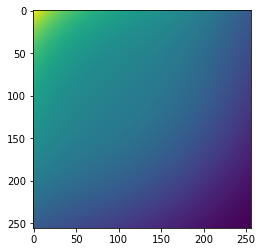

In [ ]:
plt.imshow(bf[0])

In [ ]:
image[0][0].shape
image = image/255



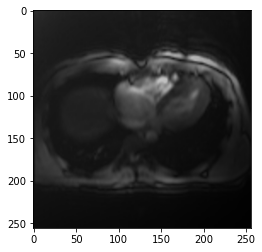

In [ ]:
image = torch.from_numpy(image)
result = image[0][0] * bf[0]
result = torch.stack((result,result,result))
result = np.array((torch.clamp(result,0,1)))
result = result*255
result = result.astype(np.uint8)
result = np.moveaxis(result, 0, 2)
result = Image.fromarray(result)
plt.imshow(result)

In [ ]:
#export
def biasfieldTransform(image, coef, order=3):
    image = np.array(image)[:,:,0]
    image = np.expand_dims(np.array(image), 0)
    image = np.expand_dims(np.array(image), 0)
    image = image/255
    coefficients = RandomBiasField().get_params(3,[coef,coef])
    bf = BiasField.generate_bias_field(image, order=3, coefficients=coefficients)
    bf[0] = torch.clamp(torch.Tensor(bf[0]),0,1)
    image = torch.from_numpy(image)
    image = image[0][0] * bf[0]
    image = torch.stack((image,image,image))
    image = np.array((torch.clamp(image,0,1)))
    image = image*255
    image = image.astype(np.uint8)
    image = np.moveaxis(image, 0, 2)
    image = Image.fromarray(image)
    return image 

def get_biasfield_series(image, model, start=0, end=-.6, step=-.2, order=3, **kwargs):
    return get_generic_series(image,model,partial(biasfieldTransform,order=order), start=start, end=end, step=step, **kwargs)

  0%|          | 0/6 [00:00<?, ?it/s]

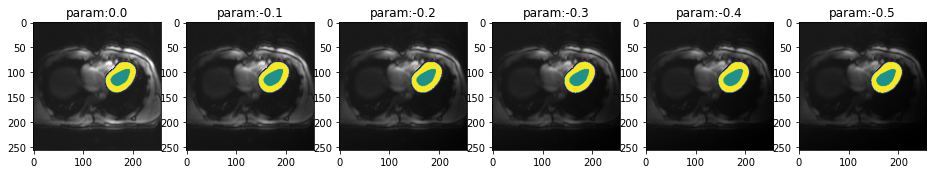

In [ ]:
plot_series(get_biasfield_series(img(),trainedModel,step=-.1),nrow=1)

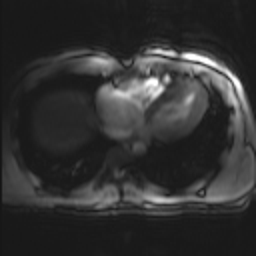

In [ ]:
biasfieldTransform(img(),0)


In [ ]:
#export
def eval_biasfield_series(image, mask, model, step=-.05, start=0, end=-.55, order=3, **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(biasfieldTransform,order=order),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name="coefficient",
        **kwargs
    )

  0%|          | 0/11 [00:00<?, ?it/s]

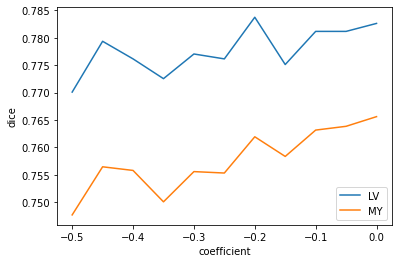

In [ ]:
results = eval_biasfield_series(img(), trueMask(), trainedModel)
plt.plot(results['coefficient'], results['c1'], label='LV')
plt.plot(results['coefficient'], results['c2'], label='MY')
plt.legend()
plt.xlabel('coefficient')
_ = plt.ylabel('dice')